# Simple Agentic RAG Workflow
This agentic workflow retrieves relevant information from a PDF, generates an answer with APA-style citations, and runs it through a quality inspector loop that iteratively refines the answer until it meets the user's requirements or reaches a maximum number of iterations.

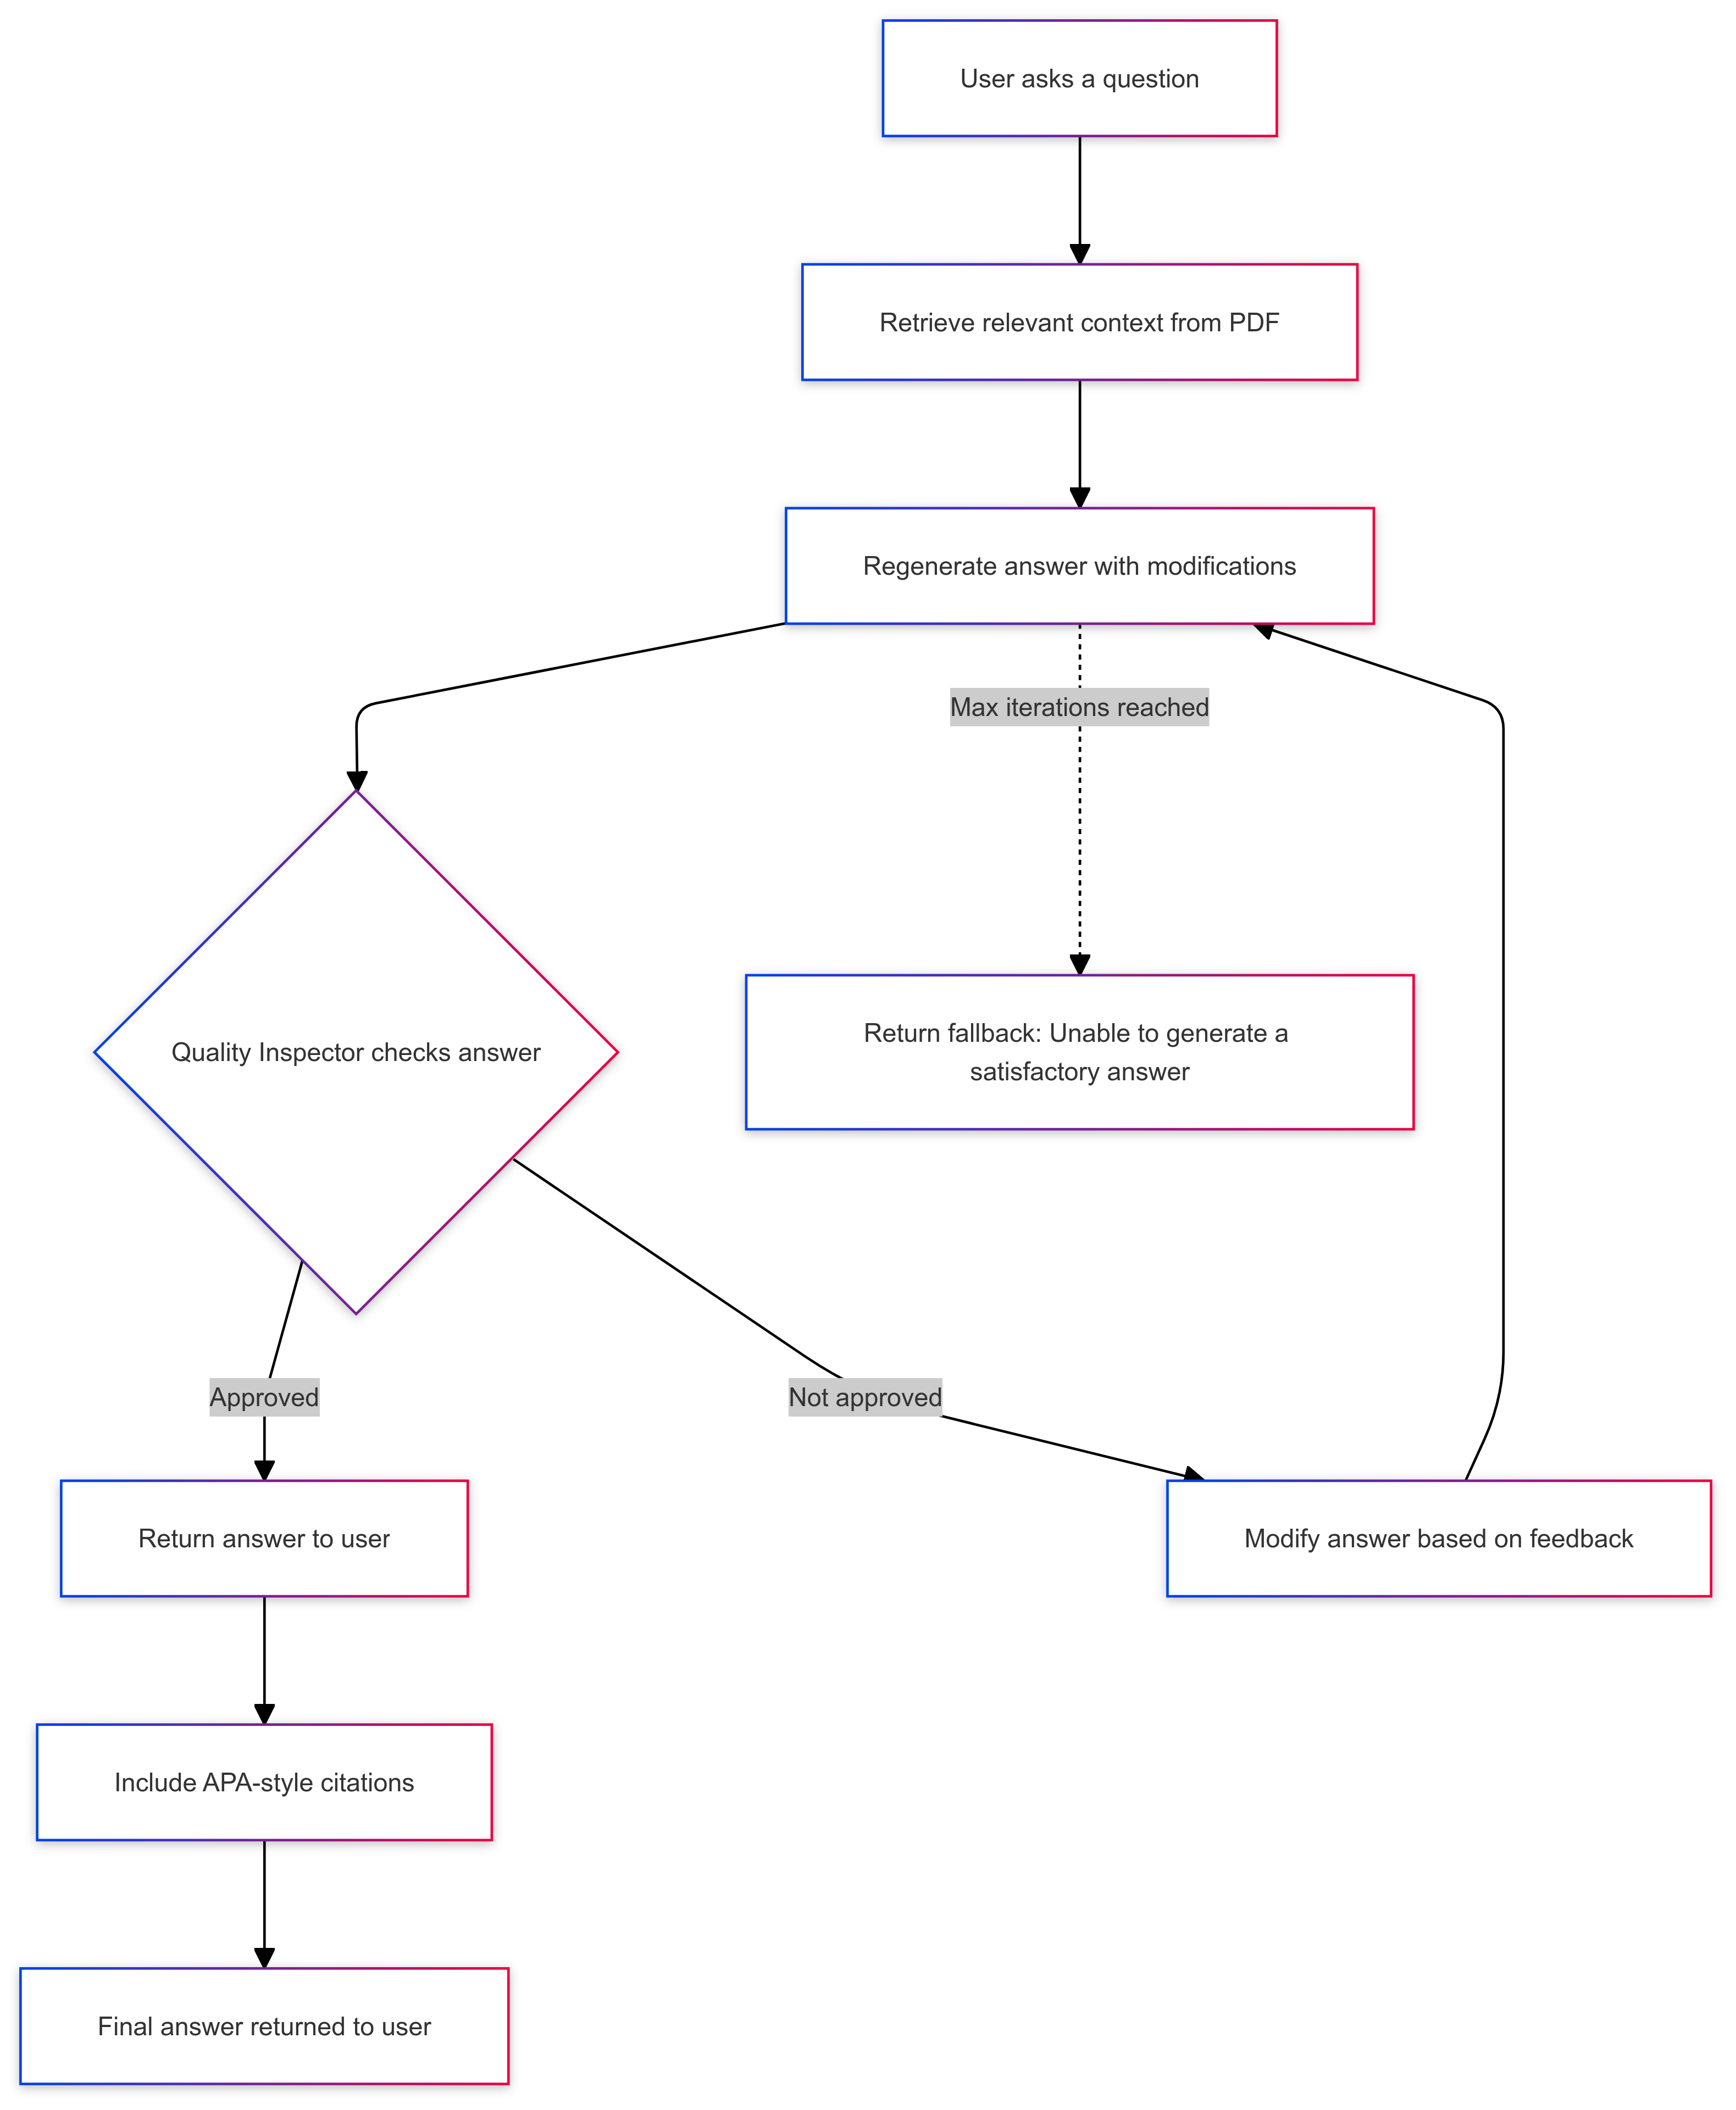

Explanation of the Workflow:
User Input:

The user asks a question.
Retrieve Context:

The system retrieves relevant context from the PDF (e.g., 5 most similar sections).
Generate Initial Answer:

Using the retrieved context, an initial answer is generated along with APA-style citations.
Quality Inspection:

The quality inspector checks the generated answer to see if it meets the user's requirements.
Approval Process:

If the quality inspector approves the answer, it's returned to the user.
If the answer is not approved, feedback is given, and the system modifies the answer accordingly.
Regenerate Answer:

After modification, the answer is regenerated and sent through the quality inspection loop again.
Max Iterations:

If a satisfactory answer cannot be generated after a set number of iterations, the system informs the user that it could not produce a satisfactory answer.
Final Answer:

If approved, the final answer (with citations) is returned to the user.

# This example below is to make a basic Q&A interface based interface
- Built as an example to creating agentic workflows
- Allows a comparison of output against the ACS Historian GPT in the GPT Store for the same question.

In [1]:
# Install necessary packages if not already installed
# !pip install langchain langchain-openai langchain-community pypdf faiss-cpu

import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate

# Set your OpenAI API key
# NOTE: It is best practice to store your API key in an environment variable rather than 
# hardcoding it in your code. It's being 'hardcoded' for simplicity in this example.
openai_api_key = ''  # Replace with your actual API key

In [ ]:

# Step 1: Load and Split PDF Text
loader = PyPDFLoader('... /Downloads/history-of-the-acs.pdf')  # Replace with your PDF file path
documents = loader.load()

# Add metadata (e.g., page numbers)
for doc in documents:
    doc.metadata['page_number'] = doc.metadata.get('page', None)
    doc.metadata['source'] = f"Page {doc.metadata['page_number']}"

# Split the documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

# Step 2: Generate Embeddings and Create Vector Store
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
vectorstore = FAISS.from_documents(texts, embeddings)



In [ ]:
# Step 3: Set Up the Language Model and Prompts

# Main QA prompt
qa_prompt_template = """
You are an AI assistant that provides answers with APA-style in-text citations based on the provided context.

Context:
{context}

Question: {question}

Provide a concise answer, including APA-style in-text citations.
"""

QA_PROMPT = PromptTemplate(
    template=qa_prompt_template, input_variables=["context", "question"]
)

# Quality Inspector prompt
inspector_prompt_template = """
You are a Quality Inspector Copy Editor. Your job is to review the following answer for correctness, completeness, and adherence to the request. Compare it against the question and the context.

Question: {question}

Context Summary:
{context_summary}

Answer to Review:
{answer}

Instructions:
- If the answer is satisfactory, respond with "Approved".
- If the answer is not satisfactory, provide specific feedback on what needs to be improved.

Your Response:
"""

INSPECTOR_PROMPT = PromptTemplate(
    template=inspector_prompt_template, input_variables=["question", "context_summary", "answer"]
)

# Initialize the LLM
llm = OpenAI(openai_api_key=openai_api_key, temperature=0)

# Step 4: Create the Retrieval QA Chain with Sources
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs={
        "prompt": QA_PROMPT,
        "document_variable_name": "context"  # Aligns with your prompt
    }
)

# Step 5: Define the Quality Inspection Function
def quality_inspect(question, context_summary, answer):
    inspector_input = INSPECTOR_PROMPT.format(
        question=question,
        context_summary=context_summary,
        answer=answer
    )
    inspection_result = llm.invoke(inspector_input)
    return inspection_result.strip()

# Step 6: Implement the Answer Function with Quality Inspection Loop
def answer_question(question, max_iterations=3):
    # Retrieve relevant context
    relevant_docs = vectorstore.similarity_search(question, k=5)
    context = "\n\n".join([doc.page_content for doc in relevant_docs])
    context_summary = context[:1000] + '...' if len(context) > 1000 else context  # Summarize if too long

    # Initialize variables
    iterations = 0
    approved = False
    answer = ""

    while not approved and iterations < max_iterations:
        iterations += 1

        # Generate the answer
        result = qa_chain.invoke({"question": question})
        answer = result['answer']
        sources = result.get('sources', '')

        # Perform quality inspection
        inspection = quality_inspect(question, context_summary, answer)

        if "Approved" in inspection:
            approved = True
        else:
            # Modify the answer based on feedback (simplified for this example)
            answer += "\n\n[Revision Notes: " + inspection + "]"

    if approved:
        return f"{answer}\n\nSources: {sources}"
    else:
        return "I'm sorry, but I couldn't generate a satisfactory answer based on the provided information."



In [ ]:
# Example Usage
user_question = "Why what the ACS Created?"
answer = answer_question(user_question)
print("Answer:", answer)